In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
import deepinv as dinv
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, plot_error_bars
from deepinv.models.complex import to_complex_denoiser

In [3]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
device

Selected GPU 0 with 32497 MB free memory 


device(type='cuda', index=0)

In [4]:
plt.style.use(['science','ieee'])

# Pseudorandom Model

## compare number of layers

In [8]:
# load data
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/data/latest/number_of_layers/pseudorandom")

res_1 = pd.read_csv(load_path /"res_pseudorandom_1_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
res_2 = pd.read_csv(load_path / "res_pseudorandom_2_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
res_3 = pd.read_csv(load_path / "res_pseudorandom_3_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")
res_4 = pd.read_csv(load_path / "res_pseudorandom_4_spectral_100repeat_5000iter_2.0284664630889893-4.983266830444336.csv")

oversampling_ratios = res_1["oversampling_ratio"]

res_1.head(n=10)
res_1.dtypes

Unnamed: 0              int64
oversampling_ratio    float64
repeat0               float64
repeat1               float64
repeat2               float64
                       ...   
repeat95              float64
repeat96              float64
repeat97              float64
repeat98              float64
repeat99              float64
Length: 102, dtype: object

In [6]:
# inspect

1 layer
2 layers
3 layers
4 layers
Figure saved to layers.svg


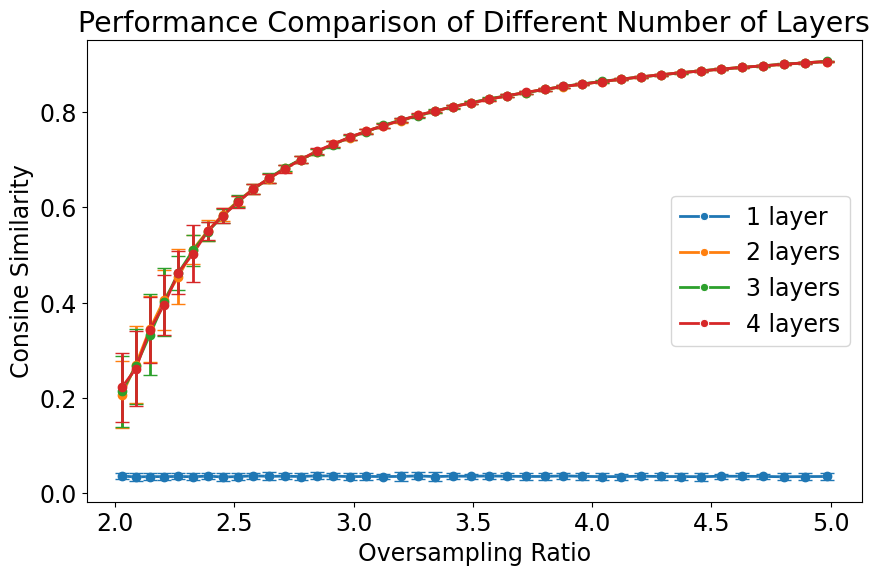

In [9]:
# plot
plot_error_bars([oversampling_ratios]*4,
                [res_1,res_2,res_3,res_4],
                ["1 layer","2 layers","3 layers", "4 layers"],
                title="Performance Comparison of Different Number of Layers",
                save="layers.svg")

# plot reconstruction comparison

torch.Size([1, 1, 99, 99])


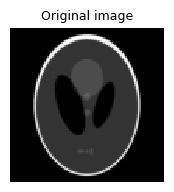

In [4]:
# generate signal
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image")

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [5]:
# create 3 models with different oversampling: 2.0, 2.5, 3.0

output_sizes = {1:141, 2:157, 3:173}
recons = [x]

def spectral_methods_wrapper(y, physics, **kwargs):
    x = spectral_methods(y, physics, n_iter=5000, **kwargs)
    z = spectral_methods(y, physics, n_iter=5000, **kwargs)
    return {"est": (x, z)}

for i in range(1,4):
    physics = dinv.physics.PseudoRandomPhaseRetrieval(
        n_layers=2,
        input_shape=(1, img_size, img_size),
        output_shape=(1, output_sizes[i], output_sizes[i]),
        drop_tail=True,
        shared_weights=True,
        dtype = torch.cfloat,
        device=device,
    )

    y = physics.forward(x_phase)

    params_algo = {"stepsize": 3e-3*physics.oversampling_ratio.item(), "g_params": 0.00}

    model = optim_builder(
        iteration="PGD",
        prior=dinv.optim.prior.Zero(),
        data_fidelity=dinv.optim.data_fidelity.L2(),
        early_stop=True,
        max_iter=20000,
        verbose=False,
        params_algo=params_algo,
        custom_init=spectral_methods_wrapper,
    )

    x_phase_recon = model(y, physics, x_gt=x_phase)
    x_phase_recon = correct_global_phase(x_phase_recon,x_phase)
    x_recon = torch.angle(x_phase_recon) / (2*torch.pi) + 0.5
    recons.append(x_recon)

Image 0, channel 0 does not have a global phase shift.
Image 0, channel 0 does not have a global phase shift.
Image 0, channel 0 does not have a global phase shift.


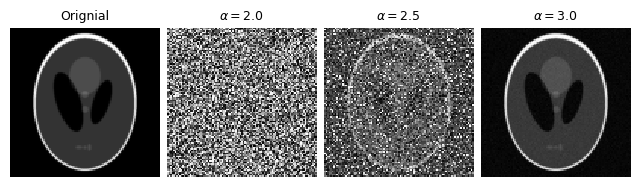

In [6]:
# visuliazation
plot(recons, titles=["Orignial",r"$\alpha=2.0$", r"$\alpha=2.5$", r"$\alpha=3.0$"],save="recons.svg")

# Random Model

## spectral

In [ ]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/20240709-080731/random")

oversampling_ratios = torch.load(load_path / "oversampling_ratios_spec_100repeat.pt")
res = torch.load(load_path / "res_spec_100repeat.pt")

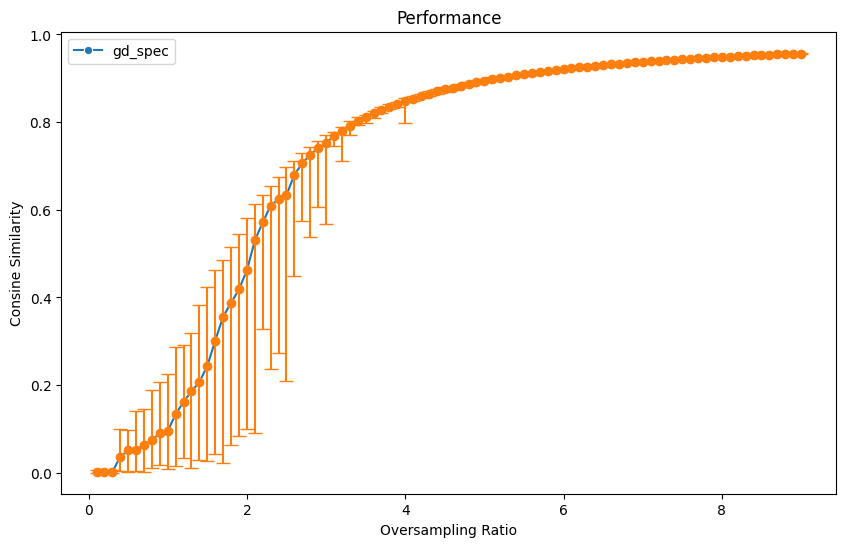

In [4]:
plot_error_bars([oversampling_ratios], [res], ['gd_spec'])

### increase iterations can reduce variance

In [4]:
load_path = Path("/home/zhhu/workspaces/deepinv/experimental/paper/data/20240710-133611/random")

oversampling_ratios = torch.load(load_path / "oversampling_ratios_spec_100repeat_2000iter_0-3.pt")
res = torch.load(load_path / "res_spec_100repeat_2000iter_0-3.pt")

gd_spec


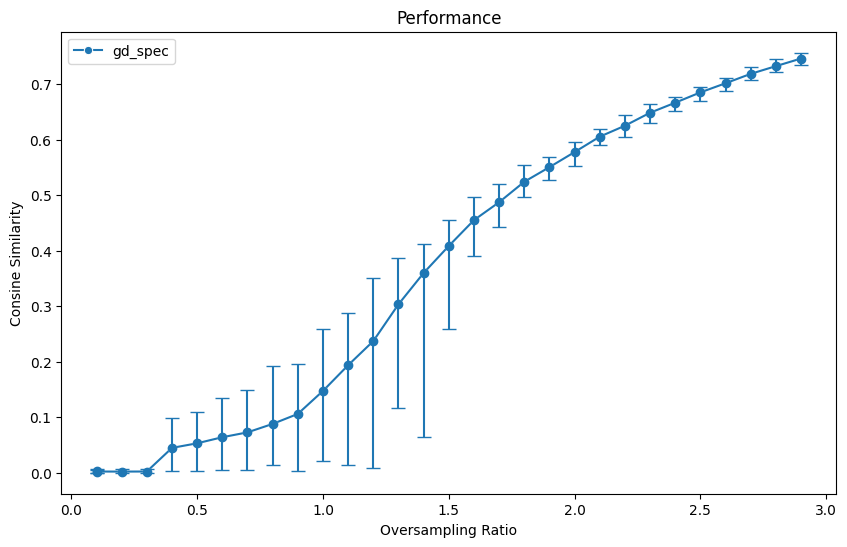

In [5]:
plot_error_bars([oversampling_ratios], [res], ['gd_spec'])

## gd spectral

In [5]:
oversampling_ratios = torch.load("/home/zhhu/workspaces/deepinv/experimental/paper/data/20240717-092224/random/oversampling_ratios_gd_spec_20repeat_5000iter_1-3_haar.pt")
res = torch.load("/home/zhhu/workspaces/deepinv/experimental/paper/data/20240717-092224/random/res_gd_spec_20repeat_5000iter_1-3_haar.pt")

gd_spec_haar


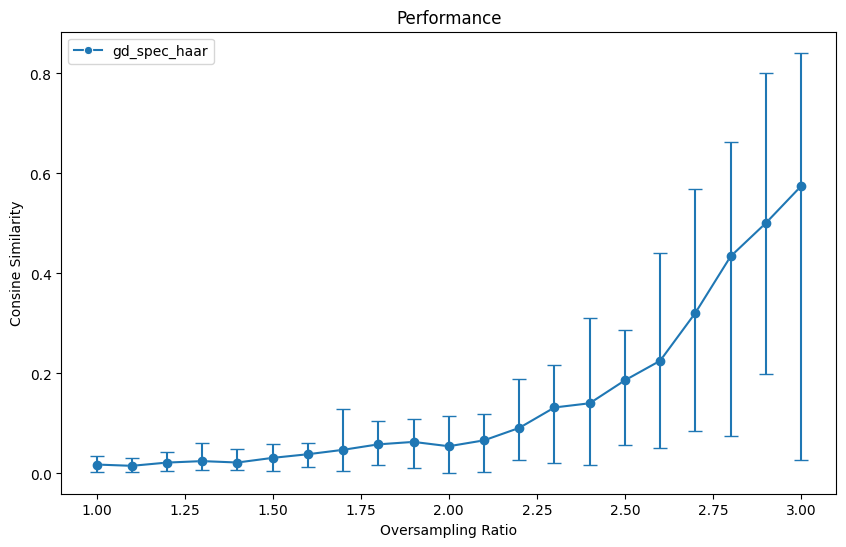

In [6]:
plot_error_bars([oversampling_ratios], [res], ['gd_spec_haar'])

# Plot

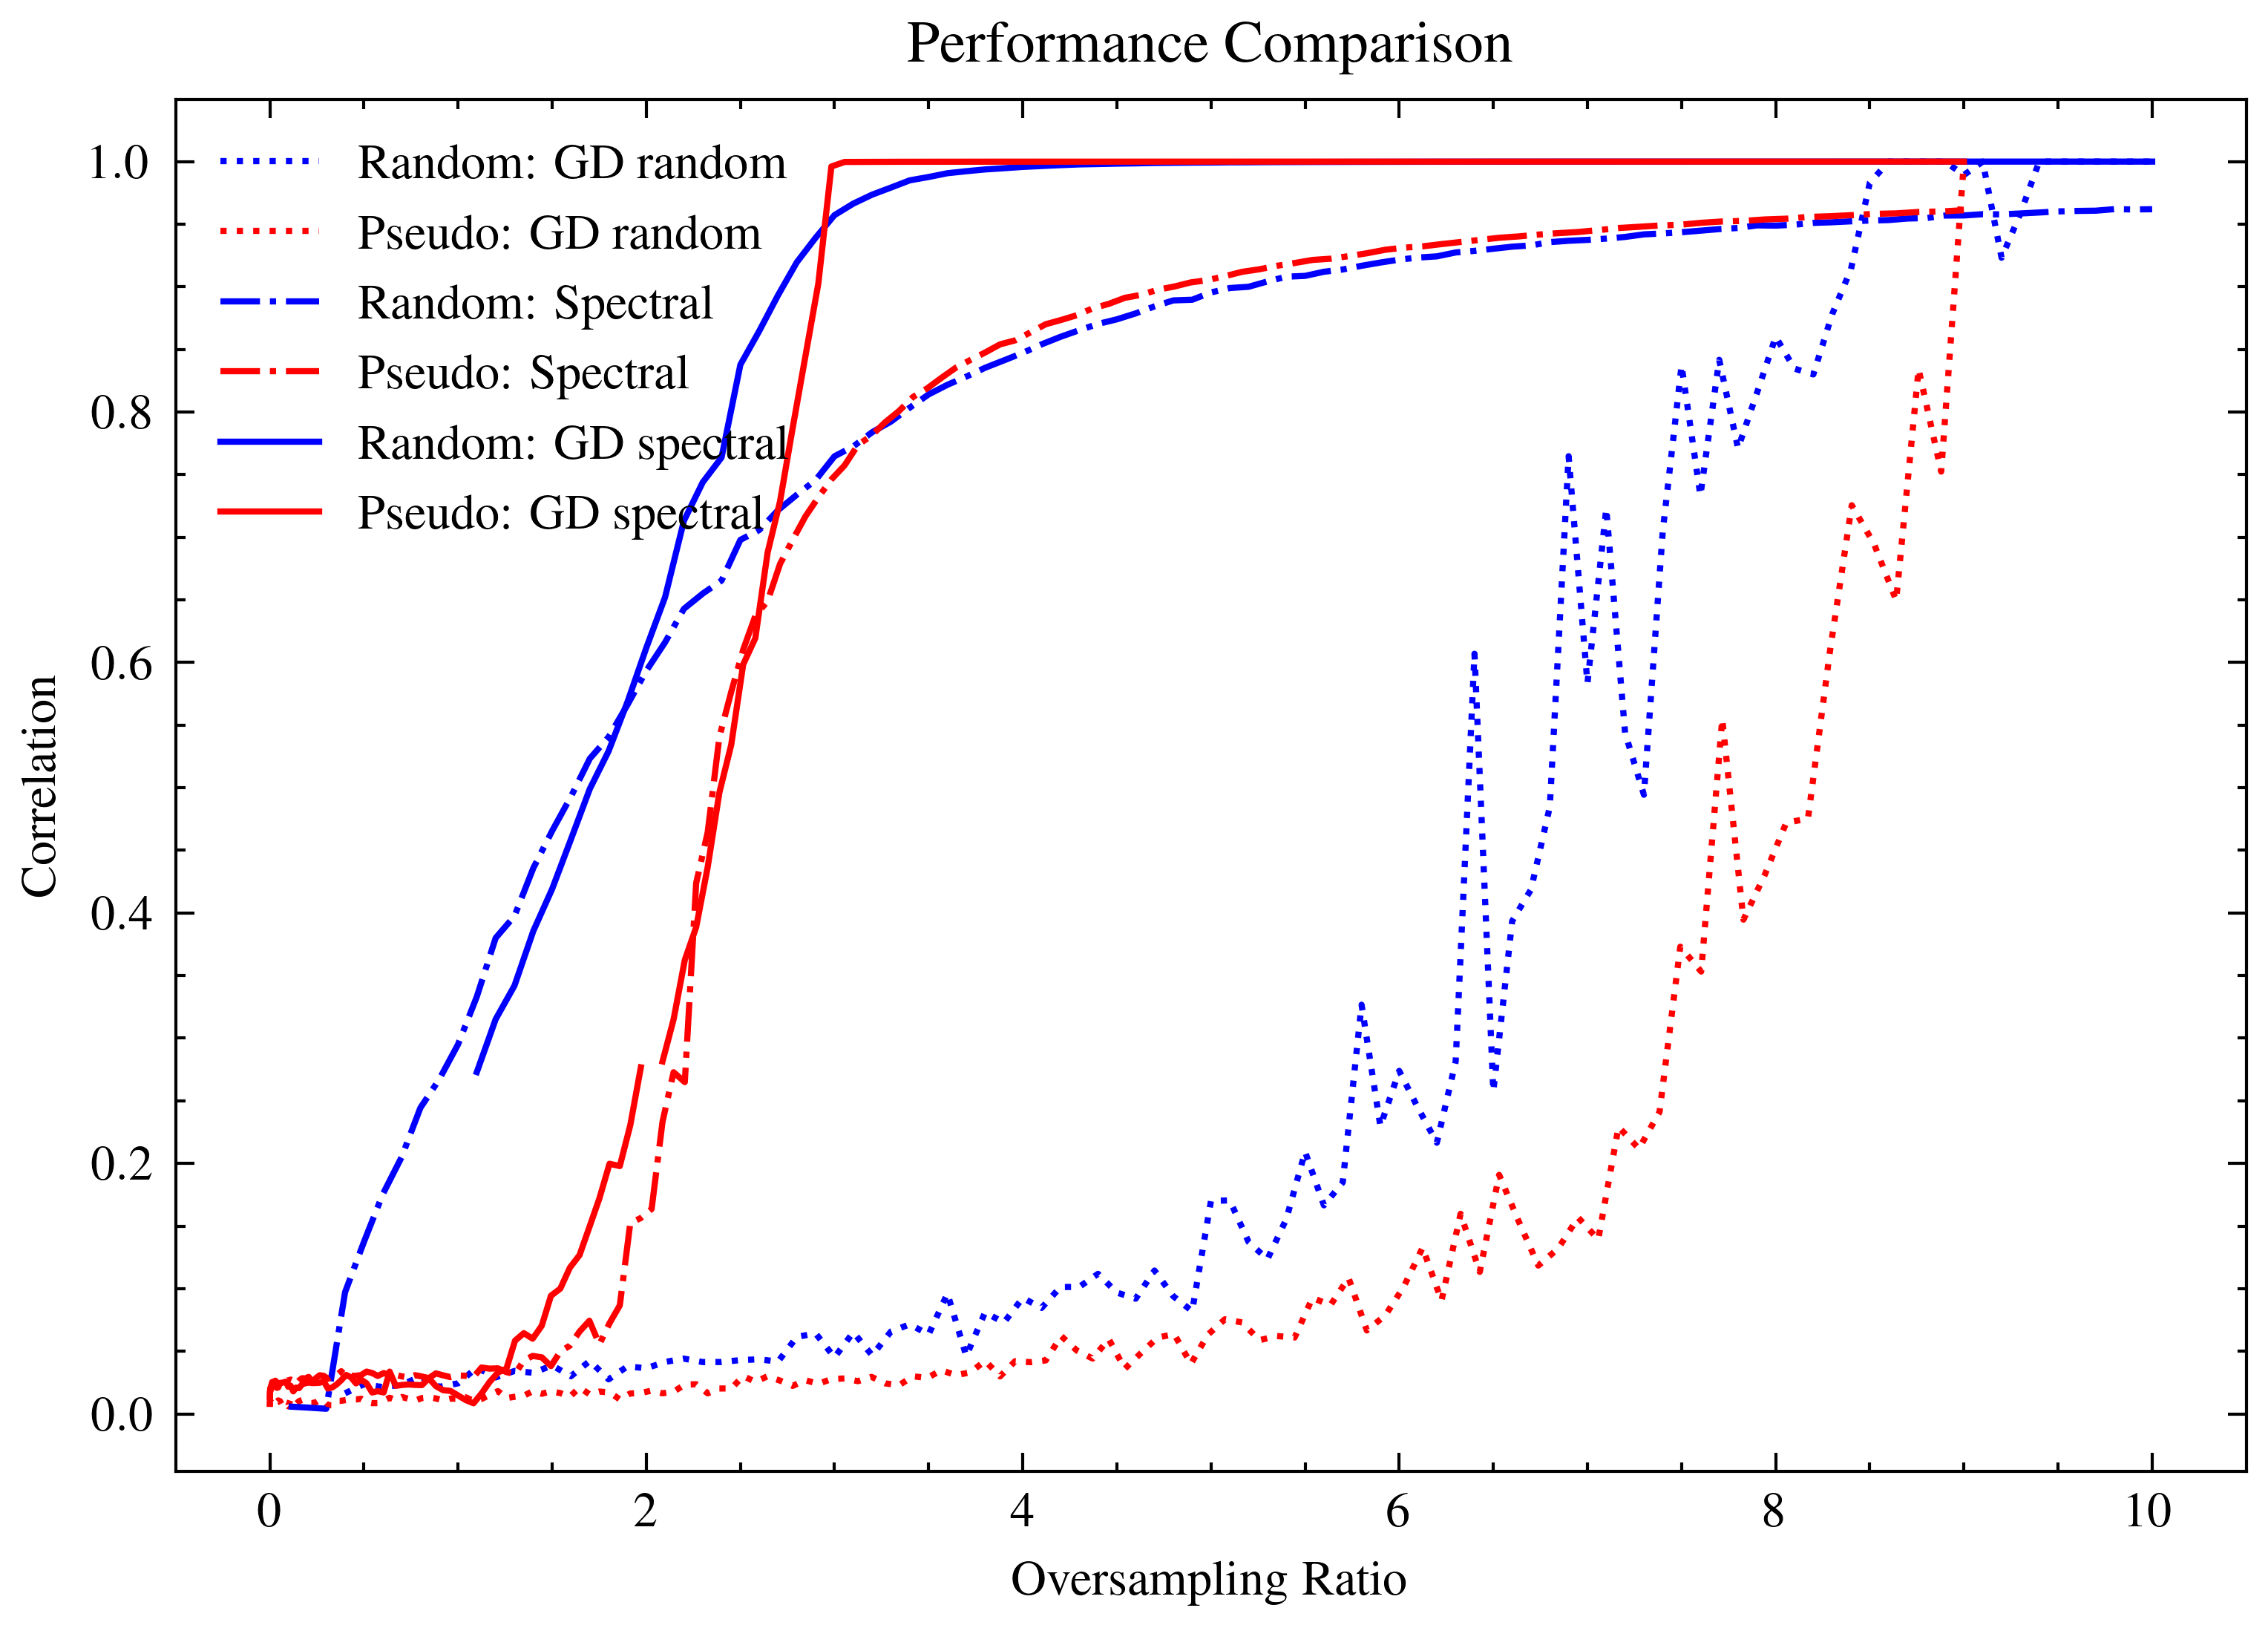

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(oversampling_ratios_rpr, res_gd_rand_rpr, label="Random: GD random", color="blue", linestyle="dotted")
plt.plot(oversampling_ratios, res_gd_rand, label="Pseudo: GD random", color="red", linestyle="dotted")
plt.plot(oversampling_ratios_rpr, res_spec_rpr, label="Random: Spectral", color="blue", linestyle="dashdot")
plt.plot(oversampling_ratios, res_spec, label="Pseudo: Spectral", color="red", linestyle="dashdot")
plt.plot(oversampling_ratios_rpr, res_gd_spec_rpr, label="Random: GD spectral", color="blue", linestyle="solid")
plt.plot(oversampling_ratios_gd_spec, res_gd_spec, label="Pseudo: GD spectral", color="red", linestyle="solid")
plt.xlabel("Oversampling Ratio")
plt.ylabel("Correlation")
plt.legend(loc="upper left")
plt.title("Performance Comparison")
plt.show()